# Instructions

1. Run the cells below and verify that indeed the output is as expected.
2. Trace through the lines and estimate the computational complexity of calculating the mean for
    - the full gaussian process
    - the sparse gaussian process
3. Trace through the lines and estimate the computational complexity of calculating the *covariance* for
    - the full gaussian process
    - the sparse gaussian process
4. (Time permitting) Experiment with different settings for `num_inducing`.

Hints:
 - matrix multiplication of an NxK matrix with a KxM matrix results in an NxM matrix with computational complexity O(NMK)
 - the inverse of a matrix of size M has computational complexity O(M³)
 - for consistency, use N as the number of datapoints, and M as the number of inducing points

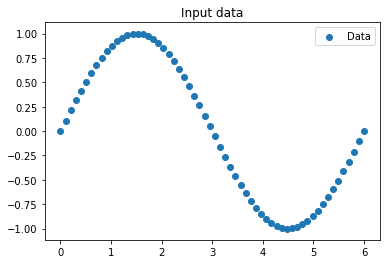

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import GPy

x_max = 6
n_full = 60

x_full = np.linspace(0, x_max, n_full).reshape(-1, 1)
y_full = np.sin(x_full / x_max * 2 * np.pi)
sigma = 1e-3

plt.figure()
plt.scatter(x_full, y_full, label='Data')
plt.title('Input data')
plt.legend()


Full gaussian mean time: 0.4830000000008994 ms
Full gaussian covariance time: 0.4939999999997724 ms


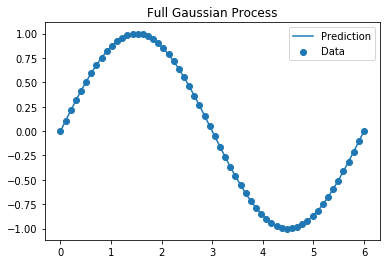

In [18]:
import time
import numpy as np
import matplotlib.pyplot as plt
import GPy

ndim = 1
rbf = GPy.kern.RBF(ndim)

x_full = np.linspace(0, x_max, n_full).reshape(-1, 1)
y_full = np.sin(x_full / x_max * 2 * np.pi)
sigma = 1e-3

knn = rbf.K(x_full, x_full)

# The full predictions for a Gaussian Process:
common = np.linalg.inv((sigma**2) * np.eye(n_full) + knn)

start = time.process_time()
mean = np.dot(np.dot(knn, common), y_full)
end = time.process_time()

full_gaussian_mean = end-start

start = time.process_time()
covariance = knn - np.dot(np.dot(knn, common), knn)
end = time.process_time()

full_gaussian_cov = end-start

#print(mean)
#print(covariance)

plt.figure()
plt.scatter(x_full, y_full, label='Data')
plt.plot(x_full, mean, label='Prediction')
plt.title('Full Gaussian Process')
plt.legend()

print(f"Full gaussian mean time: {full_gaussian_mean*1000} ms")
print(f"Full gaussian covariance time: {full_gaussian_cov*1000} ms")



Sparse gaussian mean time: 0.08599999999781005 ms
Sparse gaussian covariance time: 0.5410000000001247 ms


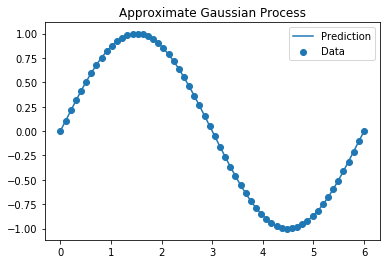

In [17]:
# The predictions for a sparse Gaussian process:
n_inducing = 10
inducing = np.linspace(0, x_max, n_inducing).reshape(-1, 1)
knm = rbf.K(x_full, inducing)
kmm = rbf.K(inducing, inducing)
kmn = rbf.K(inducing, x_full)

kmm_inv = np.linalg.inv(kmm)

# # Show the approximate covariance:
# approximate = np.dot(knm, np.dot(kmm_inv, kmn))
# print(approximate)
# # Now show the full covariance:
# print(knn)

# This is taken directly from the eqations (6) and (10) in the 
# Titsias (2009)
SIGMA = np.linalg.inv(kmm + (sigma**(-2.0)) * np.dot(kmn, knm))
MU = (1.0 / sigma)**2 * np.dot(np.dot(np.dot(kmm, SIGMA), kmn), y_full)
A = np.dot(np.dot(kmm, SIGMA), kmm)
B = np.dot(np.dot(kmm_inv, A), kmm_inv)

start = time.process_time()
mean_induced = np.dot(np.dot(knm, kmm_inv), MU)
end = time.process_time()

sparse_gaussian_mean = end-start

start = time.process_time()
covariance_induced = knn - np.dot(np.dot(knm, kmm_inv), kmn) + np.dot(
    np.dot(knm, B), kmn)
end = time.process_time()

sparse_gaussian_cov = end-start

# print(mean_induced)
# print(covariance_induced)

plt.figure()
plt.scatter(x_full, y_full, label='Data')
plt.plot(x_full, mean_induced, label='Prediction')
plt.title('Approximate Gaussian Process')
plt.legend()

print(f"Sparse gaussian mean time: {sparse_gaussian_mean*1000} ms")
print(f"Sparse gaussian covariance time: {sparse_gaussian_cov*1000} ms")